<a href="https://colab.research.google.com/github/inbarhub/YDATA_DL_assignments_2021-2022/blob/main/H.W_2_cifar_school_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Neural Network for CIFAR dataset
In this exercise, you should take the network from H.W_1 and change it to fit to this new dataset.

CIFAR is a dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model

Instead of loading a pre-trained model, we will guide you to define a new architecture.

## Loading CIFAR dataset

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). As was done in the previous exercise, you should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data. 

You can use batch_size = 128

In [142]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy

transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

Files already downloaded and verified
Files already downloaded and verified


In [143]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualize some of the training images

In this dataset the size of the images are 32x32. 

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?) 

The code below was taken from H.W_1

In [144]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [145]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

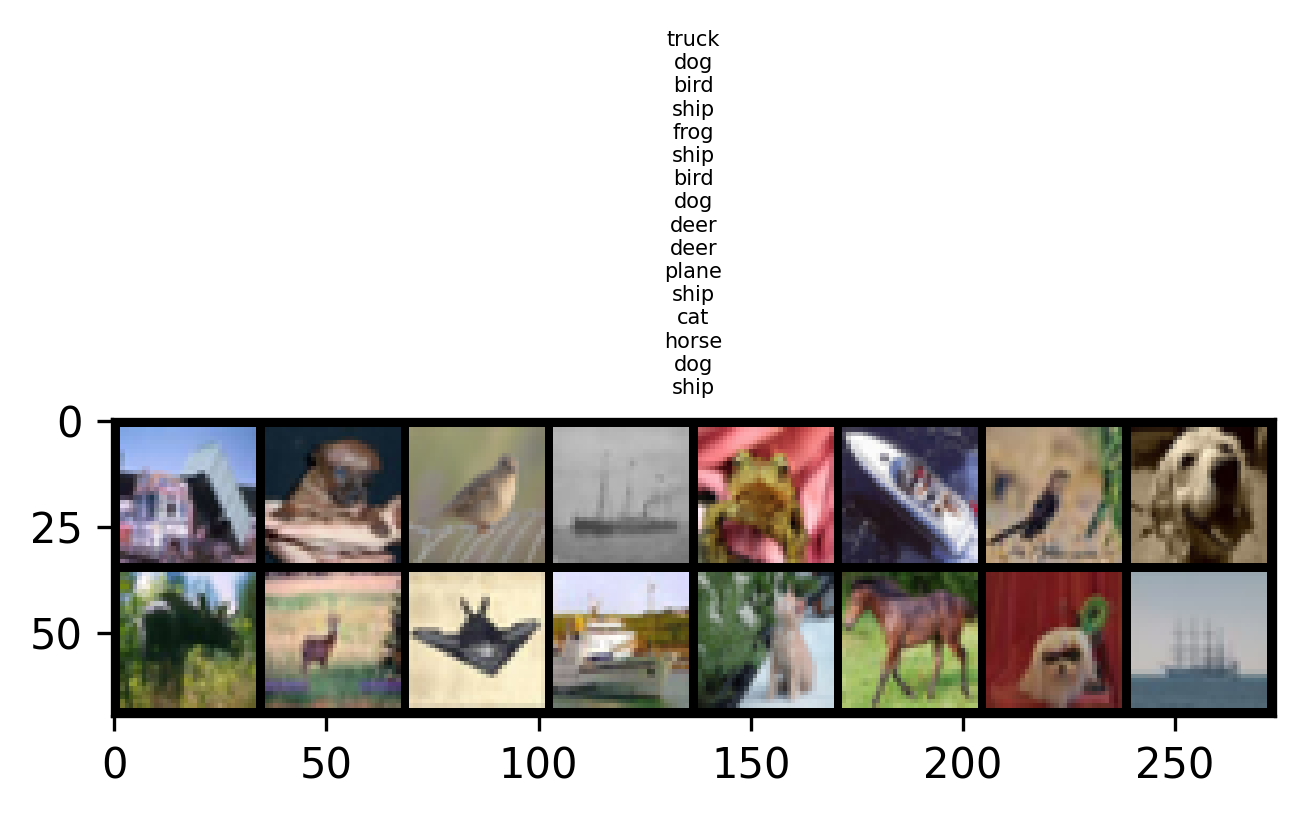

In [146]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

In [147]:
out.shape

torch.Size([3, 70, 274])

## A 2-layer Neural Network

We will define 2-layer network 

In [148]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(32*32*3, 100),
        #     nn.ReLU(),
        #     nn.Linear(100, 20),
        #     nn.ReLU(),
        #     nn.Linear(20, 10),
        #     # SCHOOL SOLUTION
        #     nn.LogSoftmax(dim=1)
        # )
        ### SCHOOL SOLUTION
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )
        # School Solution


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [149]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


**Pay attention, in case you change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**

**You should tun again the line** ``model = NeuralNetwork().to(device)``

In [150]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
# optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
### SCHOOL SOLUTION
optimizer_ft = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [151]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #School solution
    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}
    #School solution

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                ### SCHOOL SOLUTION
                inputs = inputs-torch.mean(inputs)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                ### SCHOOL SOLUTION
                l1 = 0
                for p in model.parameters():
                  # l1 += torch.norm(p)
                  l1 += torch.sum(torch.abs(p))
                running_loss += 0.1*l1
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #School solution
            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc
            #School solution

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

In [152]:
model,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.1494 Acc: 0.2798
val Loss: 1.9300 Acc: 0.3576

Epoch 1/9
----------
train Loss: 1.8391 Acc: 0.3918
val Loss: 1.7593 Acc: 0.4197

Epoch 2/9
----------
train Loss: 1.7118 Acc: 0.4386
val Loss: 1.6709 Acc: 0.4548

Epoch 3/9
----------
train Loss: 1.6265 Acc: 0.4719
val Loss: 1.6194 Acc: 0.4748

Epoch 4/9
----------
train Loss: 1.5581 Acc: 0.4992
val Loss: 1.5618 Acc: 0.4995

Epoch 5/9
----------
train Loss: 1.5002 Acc: 0.5222
val Loss: 1.5366 Acc: 0.5066

Epoch 6/9
----------
train Loss: 1.4490 Acc: 0.5401
val Loss: 1.5069 Acc: 0.5214

Epoch 7/9
----------
train Loss: 1.3784 Acc: 0.5695
val Loss: 1.4800 Acc: 0.5288

Epoch 8/9
----------
train Loss: 1.3665 Acc: 0.5730
val Loss: 1.4785 Acc: 0.5317

Epoch 9/9
----------
train Loss: 1.3588 Acc: 0.5757
val Loss: 1.4753 Acc: 0.5302

Training complete in 1m 50s
Best val Acc: 0.531700


# 1) Losses in Pytorch

Now, when you manage to run the training loop, let's understand the loss definition. PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`) that has just been used. You'll usually see the loss assigned to `criterion`. For classification problems such as CIFAR, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

Really important note. Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

**Exercise:** Change the network above to output the log-softmax and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.


# 2) Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization. Write this visualization here.


In [38]:
#School solution
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])
  plt.subplot(1,2,2); plt.plot(dict_res['train'][1]); plt.plot(dict_res['val'][1]); plt.title('Accuracy'); plt.legend(['train','val'])
#School solution


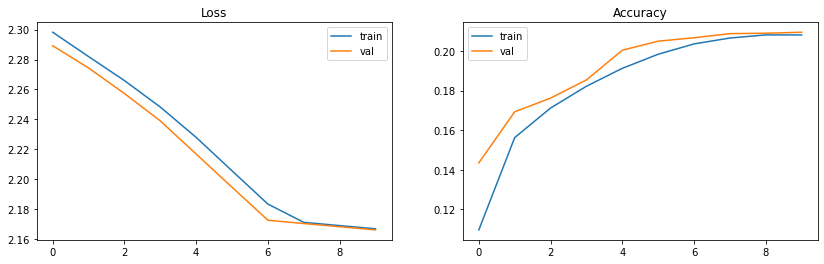

In [39]:
#School solution
plot_convergence(dict_res,num_epochs ); plt.show()
#School solution

#original code

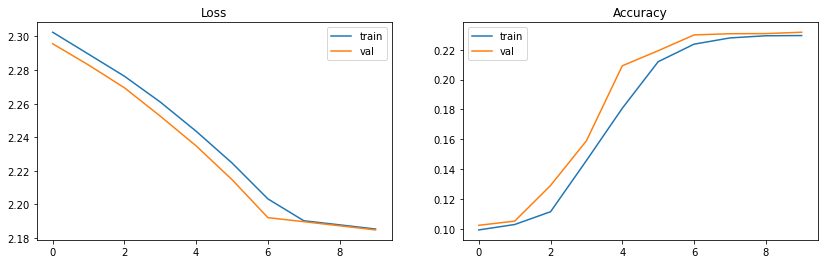

In [53]:
#School solution
plot_convergence(dict_res,num_epochs ); plt.show()
#School solution 
# with softmax

# 3) Tune your hyperparameters

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy. 

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

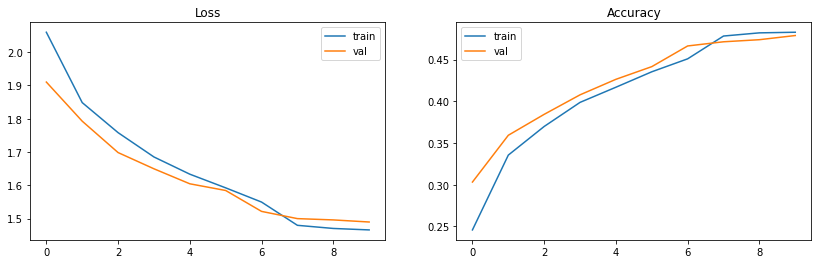

In [70]:
#School solution
plot_convergence(dict_res,num_epochs ); plt.show()
#School solution 
# enlarging the learning rate

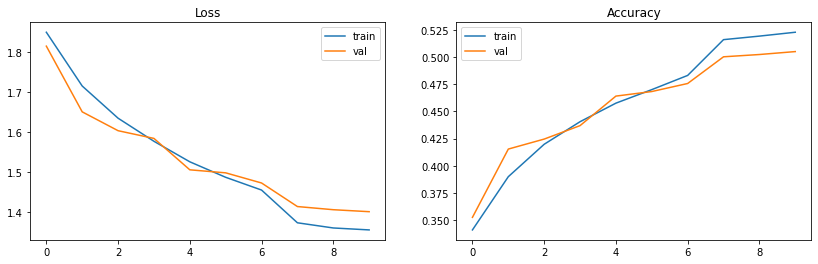

In [73]:
#School solution
plot_convergence(dict_res,num_epochs ); plt.show()
#School solution 
# enlarging the model

Bigger model can lead to a bigger gap between the training and the test-set.

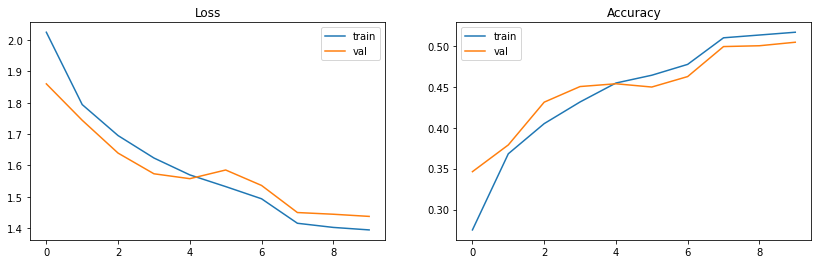

In [96]:
#School solution
plot_convergence(dict_res,num_epochs ); plt.show()
#School solution 
# add regularization

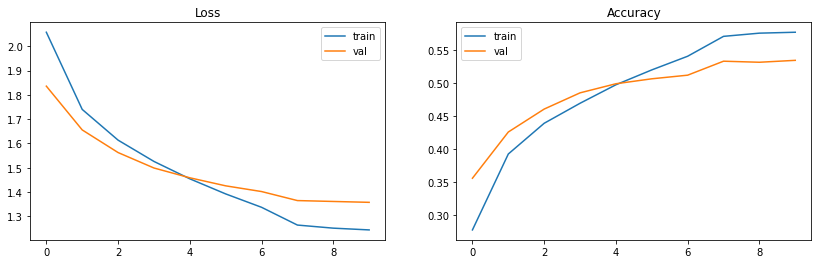

In [102]:
#School solution
plot_convergence(dict_res,num_epochs ); plt.show()
#School solution 
# add pre process

----- School solution ----

You can see in the code above some of my changes.
I tried to:

a) By analysing the loss, we definitaly see that the learning rate is too small. We can also see that the loss didn't reach to a convergance which means that we can take more epochs, or, as I tried enlarge the learning rate.

b) Change the network architecture (enlarge it). You could also try to make the network deeper, I played with the number of neurons and kept the number of layers the same. The gap between the training and the validation set becomes bigger.

c) add regularization - it did not change the accuracy but the gap is smaller now.

d) add pre prcocess (reduce the mean of the image). I added it in the training function but you could also do it in the dataloaders.


Orinigal code - 0.20

Using softmax and NLLos - 0.22



My changes:

Enlraging the learning_rate - 0.478

Enlrage the network (number of parameters and not number of layers) - 0.5

adding regularization - 0.5

adding pre prcocess - 0.53

The accuracy is much better now. We can still see the gap, so you should also have in mind to add augmentations.

Pay attenntion that in every change I do, I run the model decleration again.

----- School solution ----


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*:

1+3

*Your explanation:*

By training on a larger dataset the network will have a more diverse representation of possible inputs and would better generalize. 

Increasing the regularization strength has an effect of decreasing the network complexity, lowering overfitting, so the train-test validation gap is narrowing.

Regarding the hidden units - in general, adding complexity to the network can cause overfitting and can even increase the train-validation gap. However, sometimes the network might be too small and can not represent well the complexity of the problem. So, we need to add more hidden units in order to get a better accuracy (as was above). If we do this, we need to somwhow balance this by adding regularization and/or augmentation.

So, enlarging the network and increasing the regularization and enlarging the training dataset might do a good job.
